# Person Re-ID on Market-1501 (Ranking)

This is for generating a ranked list of images given a trained model and a query image.

First, import required modules. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../' # Expected to be in rank_scripts/

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [5]:
#getDiff Implementation
def getDiff( vector1, vector2 ):
    sum=0
    for i in range(50):
        for j in range(1024):
            diff= vector1[i][j]-vector2[i][j]
            diff=diff*diff
            sum=sum+diff
        
    return math.sqrt(sum)

In [6]:
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net(caffe_root +  'examples/_temp/unsup_net_deploy.prototxt',
                caffe_root + 'rank_scripts/models6/_iter_600.caffemodel',
                caffe.TEST)# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'rank_scripts/market_train_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [7]:
# set net to batch size of 100
net.blobs['data'].reshape(100,3,128,64)

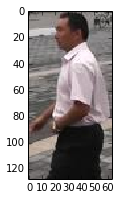

In [8]:
query_image_path = 'rank_scripts/images_market/0153_c4s1_025426_00.jpg'
query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['fc7']
plt.figure(figsize=(3,3))
plt.imshow(query_image)

In [7]:
#print vector_query[49][1023]

In [6]:
#Rank Vector Setup
num_rank = 6

In [29]:
#Paired list to hold (diff,imagePath)

Rank_list= []
query_folder = caffe_root + 'rank_scripts/images_market/'
images_list = os.listdir(query_folder)
i=10

#print images_list

for image in images_list:
    new_net = caffe.Net(caffe_root +  'examples/_temp/unsup_net_deploy.prototxt',
                caffe_root + 'rank_scripts/models5/_iter_600.caffemodel',
                caffe.TEST)
        
    new_net.blobs['data'].reshape(100,3,128,64)
    new_net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(query_folder + image))
    output=new_net.forward()
    vector_new=output['fc7']
    diff = getDiff(vector_query, vector_new)
    
    #add the pair (diff,image) to the list
    Rank_list.append((diff,image))
    
    #sort the list based on diff
    Rank_list.sort()

    #remove the last element if more than 'num_rank'
    if len(Rank_list) > num_rank :
        Rank_list.remove(Rank_list[len(Rank_list)-1])
    
print Rank_list

[(0.0, '0153_c4s1_025426_00.jpg'), (0.5607008191540137, '0154_c5s1_025926_00.jpg'), (0.5956891669817145, '0154_c3s1_025351_00.jpg'), (0.6017754361424076, '0154_c4s1_025851_00.jpg'), (0.6092372483183002, '0152_c1s1_025251_00.jpg'), (0.6320363958243723, '0152_c2s1_024601_00.jpg')]


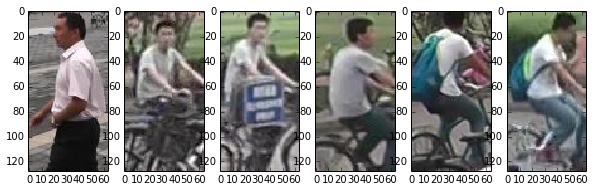

In [30]:
fig,axs = plt.subplots (nrows=1,ncols=len(Rank_list))
i=0

for item in Rank_list:
    new_image_name = item[1]
    new_image = caffe.io.load_image(query_folder + new_image_name)
    
    plt.figure(figsize=(3,3))
    axs[i].imshow(new_image)
    i=i+1

In [13]:
'''
file1 = open('check.txt','w')
for item in Rank_list:
    file1.write(item[1])
    file1.write('\n')
    
file1.close()
'''

"\nfile1 = open('check.txt','w')\nfor item in Rank_list:\n    file1.write(item[1])\n    file1.write('\n')\n    \nfile1.close()\n"